In [1]:
%reload_ext autoreload
%autoreload 2

from lib.data_loading import load_measurements, MultiBasisDataLoader

####

import re
from pathlib import Path
from typing import Optional, Tuple, Dict, Any, Sequence
from datetime import datetime

import numpy as np

import jax
import jax.lax
from jax.random import PRNGKey
import jax.numpy as jnp
import optax
from flax.training.train_state import TrainState
from flax.training import checkpoints
from flax import linen as nn

import matplotlib.pyplot as plt


data_dir = "data"
model_dir = Path("./models")
model_dir.mkdir(parents=True, exist_ok=True)

print(f"Data resides in        : {data_dir}")
print(f"Model will be saved to : {model_dir}")

Data resides in        : data
Model will be saved to : models


In [2]:
class RBM(nn.Module):
    n_visible: int
    n_hidden: int
    k: int = 1          # bound to class instance to make whole gibbs chain compilable
    T: float = 1.0      # bound to class instance to make single gibbs step compilable

    def setup(self):
        self.W = self.param("W", nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        self.b = self.param("b", nn.initializers.zeros, (self.n_visible,))
        self.c = self.param("c", nn.initializers.zeros, (self.n_hidden,))

    def __call__(self, data: jnp.ndarray, aux_vars: Dict[str, Any]) -> Tuple[jnp.ndarray, Dict[str, Any]]:
        gibbs_step_fn = lambda i, s: self._gibbs_step(s, self.W, self.b, self.c, self.T)
        gibbs_chain, key = jax.lax.fori_loop(0, self.k, gibbs_step_fn, (aux_vars["gibbs_chain"], aux_vars["key"]))
        gibbs_chain = jax.lax.stop_gradient(gibbs_chain) # cut off gradients after Gibbs sampling

        loss = jnp.mean(self._free_energy(data)) - jnp.mean(self._free_energy(gibbs_chain))
        return loss, {"gibbs_chain": gibbs_chain, "key": key}

    def _free_energy(self, v):
        return -(v @ self.b) - jnp.sum(jax.nn.softplus(v @ self.W + self.c), -1)

    @staticmethod
    def _gibbs_step(state, W, b, c, T):
        v, key = state
        key, h_key, v_key = jax.random.split(key, 3)
        h = jax.random.bernoulli(h_key, jax.nn.sigmoid((v @ W + c)/T)).astype(jnp.float32)
        v = jax.random.bernoulli(v_key, jax.nn.sigmoid((h @ W.T + b)/T)).astype(jnp.float32)
        return v, key

    @nn.nowrap
    def generate(self, n_samples: int, T_schedule: jnp.ndarray, key: PRNGKey) -> jnp.ndarray:
        key, key_init = jax.random.split(key, 2)
        v = jax.random.bernoulli(key_init, p=0.5, shape=(n_samples, self.n_visible)).astype(jnp.float32)

        anneal_fn = lambda i, s: self._gibbs_step(s, W=self.W, b=self.b, c=self.c, T=T_schedule[i])
        v_final, _ = jax.lax.fori_loop(0, len(T_schedule), anneal_fn, (v, key))
        return v_final

In [3]:
@jax.jit
def train_step_amp(
        state: TrainState,
        batch: jnp.ndarray,
        gibbs_chain: jnp.ndarray,
        key: PRNGKey,
        chain_reset_frac: float) -> Tuple[TrainState, jnp.ndarray, jnp.ndarray, PRNGKey]:

    key, key_reset, key_sample = jax.random.split(key, 3)

    # Reset mask: which chains to replace
    reset_mask = jax.random.bernoulli(key_reset, p=chain_reset_frac, shape=(batch_size, 1))

    # Sample from batch — shape (batch_size,)
    sample_idxs = jax.random.randint(key_sample, shape=(batch_size,), minval=0, maxval=batch.shape[0])
    sampled_onehots = batch[sample_idxs]  # shape (batch_size, n_visible)

    # Replace according to mask
    reset_chain = jnp.where(reset_mask, sampled_onehots, gibbs_chain)


    aux_vars = {"gibbs_chain": reset_chain, "key": key}
    loss_fn = lambda params: state.apply_fn({'params': params}, batch, aux_vars)
    (loss, aux_vars), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)

    return state, loss, aux_vars["gibbs_chain"], aux_vars["key"]


def entropy_modes(chain: jnp.ndarray) -> Tuple[float, int]:
    # translate each binary pattern to a unique integer
    chain = chain.astype(jnp.uint32)
    powers = 2 ** jnp.arange(chain.shape[-1], dtype=jnp.uint32)
    ints = jnp.dot(chain, powers)

    hist = jnp.bincount(ints, length=1 << chain.shape[-1]).astype(jnp.float32)
    probs = hist / jnp.sum(hist)
    entropy = -jnp.sum(jnp.where(probs > 0, probs * jnp.log(probs), 0.0)) # shannon entropy with guard against prob <=0
    mode_count = jnp.sum(hist > 0)
    return float(entropy), int(mode_count)


def train_amp_rbm(
        state: TrainState,
        loader: MultiBasisDataLoader,
        gibbs_chain: jnp.ndarray,
        num_epochs: int,
        key: PRNGKey,
        chain_reset_frac_min: float = 0.02,
        chain_reset_frac_max: float = 0.30,
        chain_reset_ema_alpha: float = 0.9) -> Tuple[TrainState, Dict[int, float]]:

    print("Precalculating target entropy from data.")
    all_data = []

    for base_batches, _ in loader:
        all_data.append(base_batches[0])  # shape: (batch_size, n_visible)

    all_data = jnp.concatenate(all_data, axis=0)
    entropy_target, _ = entropy_modes(all_data)

    chain_reset_frac_ema = 0.0
    metrics = {}
    for epoch in range(num_epochs):
        tot_loss = tot_entropy_chain = tot_modes_chain = 0.0
        batches = 0

        for base_batches, bases in loader:
            if base_batches.shape[0] != 1 or bases.shape[0] != 1:
                raise ValueError(f"Expected exactly one basis, got: {base_batches.shape[0]} bases")

            if not jnp.all(bases[0] == 0):
                raise ValueError(f"Only Z basis supported for amplitude RBM")

            batch = base_batches[0]

            entropy_chain, modes_chain = entropy_modes(gibbs_chain)
            chain_reset_frac_raw = jnp.abs(jnp.log(entropy_chain/entropy_target + 1e-12))  # tiny eps for stability
            chain_reset_frac_ema = chain_reset_frac_ema * chain_reset_ema_alpha + (1 - chain_reset_ema_alpha) * chain_reset_frac_raw
            chain_reset_frac = float(jnp.clip(chain_reset_frac_ema, chain_reset_frac_min, chain_reset_frac_max))

            state, loss, gibbs_chain, key = train_step_amp(state, batch, gibbs_chain, key, chain_reset_frac)

            tot_loss += float(loss)
            tot_entropy_chain += float(entropy_chain)
            tot_modes_chain += float(modes_chain)
            batches += 1

        avg_loss = tot_loss / batches
        avg_entropy_chain = tot_entropy_chain / batches
        avg_modes_chain = tot_modes_chain / batches
        lr = float(lr_schedule(state.opt_state[0].count))

        metrics[epoch] = dict(
            loss=avg_loss,
            entropy_chain=avg_entropy_chain,
            modes_chain=avg_modes_chain,
            lr=lr
        )

        print(f"Epoch {epoch+1}/{num_epochs} │ "
              f"Loss: {avg_loss:+.4f} │ "
              f"Chain Entr.: {avg_entropy_chain:.3f} │ "
              f"Chain Modes: {avg_modes_chain:.0f} │ "
              f"Chain Reset Frac.: {chain_reset_frac:.3f} │ "
              f"Learning Rate: {lr:.5f}")

    return state, metrics


def get_sigmoid_curve(high, low, steps, falloff, center_step=None):
    if center_step is None:
        center_step = steps / 2

    curve_fn = lambda step: low + (high - low) / (1 + jnp.exp(falloff * (jnp.minimum(step, steps) - center_step)))
    return curve_fn

In [4]:
#### LOADING DATA IN Z BASIS ####

data_dict_amp = load_measurements(data_dir, "w_*.txt")

keys_amp = [k for k in data_dict_amp if re.fullmatch(r"^Z+$", k)]
dict_amp = {k: data_dict_amp[k] for k in keys_amp}

empirical_freq_amp = jnp.zeros(next(iter(dict_amp.values())).shape[1])
num_total = 0

for arr in dict_amp.values():
    empirical_freq_amp += jnp.sum(arr, axis=0)
    num_total += arr.shape[0]

empirical_freq_amp /= num_total
empirical_freq_amp

Array([0.1265625 , 0.1221875 , 0.1275    , 0.12375   , 0.13      ,
       0.12859374, 0.11953125, 0.121875  ], dtype=float32)

In [14]:
batch_size      = 64        #                                               DONE
visible_units   = 8         #                                               DONE
hidden_units    = 16        # totally sufficient to capture all modes       DONE
k_steps         = 400       # higher is generally better                    GOOD FOR NOW
init_lr         = 1e-2      #                                               DONE
final_lr        = init_lr * 0.05 #                                           DONE
num_epochs      = 2000      #                                               MORE EPOCHS EVEN OUT SAMPLING FREQUENCIES
chains          = batch_size # makes chain replacement logic easier         DONE
weight_decay = 1e-2    #


key_seed = PRNGKey(42)
key, key_params, key_chains, key_dummy = jax.random.split(key_seed, 4)

model_amp = RBM(visible_units, hidden_units, k=k_steps)
batch_dummy = jnp.zeros((batch_size, visible_units), dtype=jnp.float32)
aux_vars_dummy = {"gibbs_chain": jnp.zeros((batch_size, visible_units), dtype=jnp.float32), "key": key_dummy}
variables_amp = model_amp.init({"params": key_params}, batch_dummy, aux_vars_dummy)

loader_amp = MultiBasisDataLoader(dict_amp, batch_size=batch_size, basis_encoding={'Z': 0, 'X': 1, 'Y': 2})

schedule_steps = num_epochs * len(loader_amp)
lr_schedule = get_sigmoid_curve(high=init_lr, low=final_lr, steps=schedule_steps, falloff=0.0005, center_step=schedule_steps * 0.5)
optimizer_amp = optax.adam(learning_rate=lr_schedule)

state_amp = TrainState.create(apply_fn=model_amp.apply, params=variables_amp["params"], tx=optimizer_amp)

# should come from data too but works for now
gibbs_chain = jax.random.bernoulli(key_chains, p=0.5, shape=(chains, visible_units)).astype(jnp.float32)

%time state_amp, metrics_amp = train_amp_rbm(state_amp, loader_amp, gibbs_chain, num_epochs, key=key, chain_reset_frac_min=0.02, chain_reset_frac_max=0.30, chain_reset_ema_alpha=0.9)

Precalculating target entropy from data.
Epoch 1/2000 │ Loss: -0.1971 │ Chain Entr.: 2.796 │ Chain Modes: 29 │ Chain Reset Frac.: 0.232 │ Learning Rate: 0.01000
Epoch 2/2000 │ Loss: -0.0306 │ Chain Entr.: 2.556 │ Chain Modes: 24 │ Chain Reset Frac.: 0.156 │ Learning Rate: 0.01000
Epoch 3/2000 │ Loss: -0.0387 │ Chain Entr.: 2.558 │ Chain Modes: 24 │ Chain Reset Frac.: 0.193 │ Learning Rate: 0.01000
Epoch 4/2000 │ Loss: -0.0169 │ Chain Entr.: 2.569 │ Chain Modes: 24 │ Chain Reset Frac.: 0.208 │ Learning Rate: 0.01000
Epoch 5/2000 │ Loss: -0.0121 │ Chain Entr.: 2.556 │ Chain Modes: 24 │ Chain Reset Frac.: 0.191 │ Learning Rate: 0.01000
Epoch 6/2000 │ Loss: -0.0025 │ Chain Entr.: 2.544 │ Chain Modes: 23 │ Chain Reset Frac.: 0.189 │ Learning Rate: 0.01000
Epoch 7/2000 │ Loss: -0.0124 │ Chain Entr.: 2.553 │ Chain Modes: 23 │ Chain Reset Frac.: 0.195 │ Learning Rate: 0.01000
Epoch 8/2000 │ Loss: +0.0152 │ Chain Entr.: 2.536 │ Chain Modes: 23 │ Chain Reset Frac.: 0.170 │ Learning Rate: 0.01000

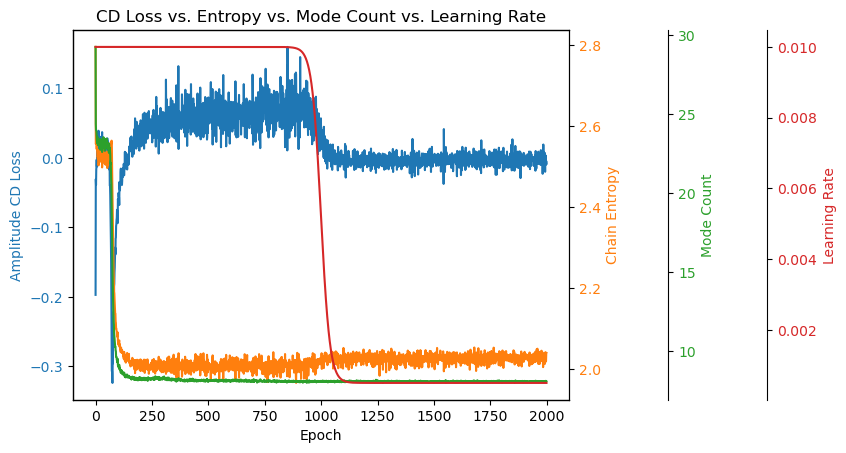

In [15]:
epochs = list(metrics_amp.keys())
loss_vals = [metrics_amp[e]['loss'] for e in epochs]
entropy_vals = [metrics_amp[e]['entropy_chain'] for e in epochs]
mode_vals = [metrics_amp[e]['modes_chain'] for e in epochs]
lr_vals = [metrics_amp[e]['lr'] for e in epochs]

fig, ax1 = plt.subplots()

ax1.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Amplitude CD Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(epochs, entropy_vals, label="Chain Entropy", color="tab:orange")
ax2.set_ylabel("Chain Entropy", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
ax3.plot(epochs, mode_vals, label="Estimated Mode Count", color="tab:green")
ax3.set_ylabel("Mode Count", color="tab:green")
ax3.tick_params(axis="y", labelcolor="tab:green")

ax4 = ax1.twinx()
ax4.spines["right"].set_position(("axes", 1.4))
ax4.plot(epochs, lr_vals, label="Learning Rate", color="tab:red")
ax4.set_ylabel("Learning Rate", color="tab:red")
ax4.tick_params(axis="y", labelcolor="tab:red")

plt.title("CD Loss vs. Entropy vs. Mode Count vs. Learning Rate")
plt.show()

In [16]:
# shifting the center step to 0 we can approximate an exponential schedule if we choose the high to be
T_high = 2.0
T_low = 0.01
sampling_steps = 10000
sigmoid_schedule_fn = get_sigmoid_curve(high=T_high*2, low=T_low, steps=sampling_steps, falloff=0.0013, center_step=0)
sigmoid_schedule = jnp.array([sigmoid_schedule_fn(i) for i in range(sampling_steps)], dtype=jnp.float32)

key_sample = PRNGKey(1234)

samples_amp = model_amp.apply(
    {"params": state_amp.params},
    n_samples=10_000,
    T_schedule=sigmoid_schedule,
    key=key_sample,
    method=RBM.generate
)

sampled_freq_amp = samples_amp.mean(0)
sampled_freq_amp

Array([0.1187    , 0.1275    , 0.1477    , 0.1248    , 0.1241    ,
       0.1147    , 0.1236    , 0.11889999], dtype=float32)

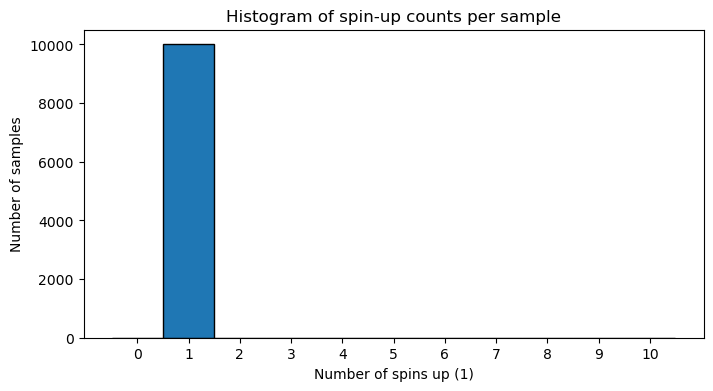

In [17]:
spin_counts = samples_amp.sum(axis=1)

plt.figure(figsize=(8, 4))
plt.hist(spin_counts, bins=range(12), align='left', edgecolor='black')
plt.xticks(range(11))
plt.xlabel("Number of spins up (1)")
plt.ylabel("Number of samples")
plt.title("Histogram of spin-up counts per sample")
plt.show()

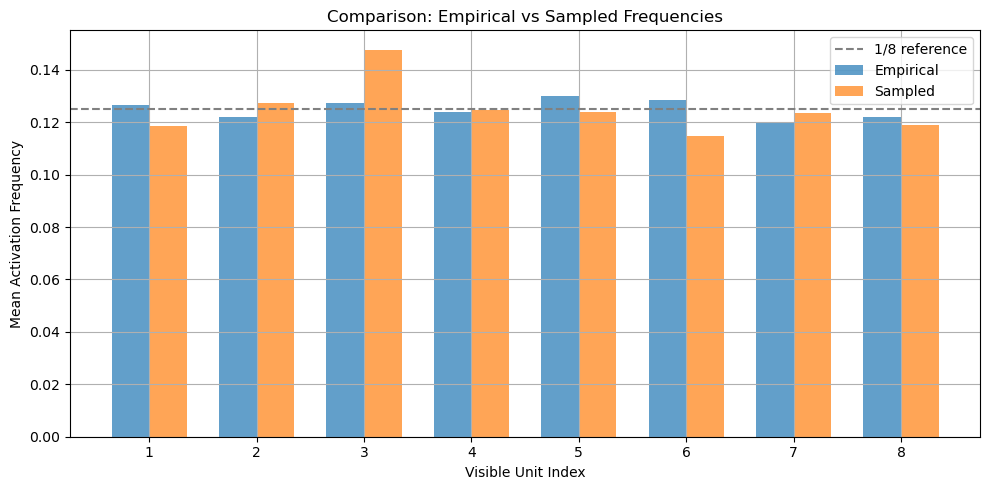

In [18]:
plt.figure(figsize=(10, 5))
x = np.arange(visible_units) + 1
width = 0.35

plt.bar(x - width/2, empirical_freq_amp, width, label="Empirical", alpha=0.7)
plt.bar(x + width/2, sampled_freq_amp, width, label="Sampled", alpha=0.7)

plt.axhline(1 / visible_units, linestyle='--', color='gray', label=f'1/{visible_units} reference')
plt.xlabel("Visible Unit Index")
plt.ylabel("Mean Activation Frequency")
plt.title("Comparison: Empirical vs Sampled Frequencies")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
timestamp = datetime.now().strftime("%Y%m%d%H%M")
model_name = f"rbm_amp_{timestamp}"

checkpoints.save_checkpoint(
    ckpt_dir=str(model_dir.resolve()),
    target=state_amp.params,
    step=0,
    prefix=model_name + "_",
    overwrite=True
)

'/Users/Tonni/Desktop/master-code/neural-quantum-tomo/case_studies/w_aug_v2/models/rbm_amp_202506110124_0'